In [1]:
from core import *
from jax import random, vmap
from jax.ops import index, index_update
from jax import jit, grad, value_and_grad
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import numpy as onp
from poppy.zernike import zernike as get_zernike

/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /import/tintagel3/snert/louis/pysynphot_models/grp/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /import/tintagel3/snert/louis/pysynphot_models/grp/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/suphys/ldes9555/anaconda3/envs/main/lib/python3.8/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /import/tintagel3/snert/louis/pysynphot_models/grp/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
aperture = 0.1
focal_length = 3.65
wavelength = 525e-9
pixel_size = 2.5e-6
array_size = 1024
npixels = 256

In [4]:
pupil_size, true_wavelength = get_wavefront_size(aperture, focal_length, wavelength, pixel_size, array_size)
print(pupil_size, true_wavelength)
print("Samlping is {:.2f}x Nyquist".format(array_size/(2*pupil_size)))
toliman_pupil = get_toliman_pupil(pupil_size)

134 5.234103455325292e-07


In [5]:
toliman_PSF = get_PSF(0, 0, toliman_pupil, aperture, focal_length, true_wavelength, pixel_size, npixels, array_size)

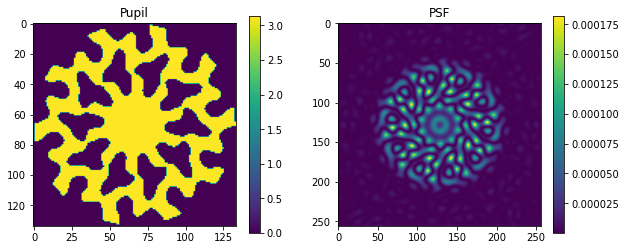

In [6]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(np.angle(toliman_pupil)))
plt.colorbar()
plt.title("Pupil")

plt.subplot(1, 2, 2)
plt.imshow(toliman_PSF)
plt.colorbar()
plt.title("PSF")

plt.show()

In [73]:
get_phase_error = lambda zernike: np.sqrt(np.nanmean(zernike**2))

nms = np.array([(2, 0), (2, -2), (2, 2), (3, -1), (3, 1)])
zern_names = ["Focus", "Astigmatism 45", "Astigmatism 0", "Coma X", "Coma Y"]
zern_names_short = ["Focus", "Astig 45", "Astig 0", "Coma X", "Coma Y"]
zernikes = []
zernikes_nan = []
for i in range(len(nms)):
    zernike_nan = get_zernike(nms[i, 0], nms[i, 1], pupil_size)
    norm_factor = 1/get_phase_error(zernike_nan)
    zernikes_nan.append(norm_factor * zernike_nan)
    zernikes.append(norm_factor * get_zernike(nms[i, 0], nms[i, 1], pupil_size, outside=0.))

In [8]:
magnitude = np.abs(toliman_pupil)
toliman_phase = np.angle(toliman_pupil)

In [9]:
aberrated_PSF_sample = []
aberrated_pupil_sample = []
for i in range(len(zernikes)):
    aberrated_pupil = get_wavefront(magnitude, toliman_phase + zernikes[i])
    aberrated_PSF = get_PSF(0, 0, aberrated_pupil, aperture, focal_length, true_wavelength, pixel_size, npixels, array_size)
    aberrated_pupil_sample.append(aberrated_pupil)
    aberrated_PSF_sample.append(aberrated_PSF)

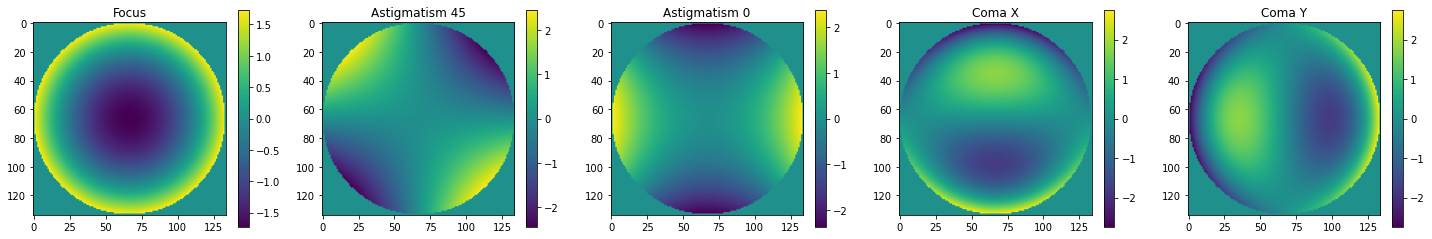

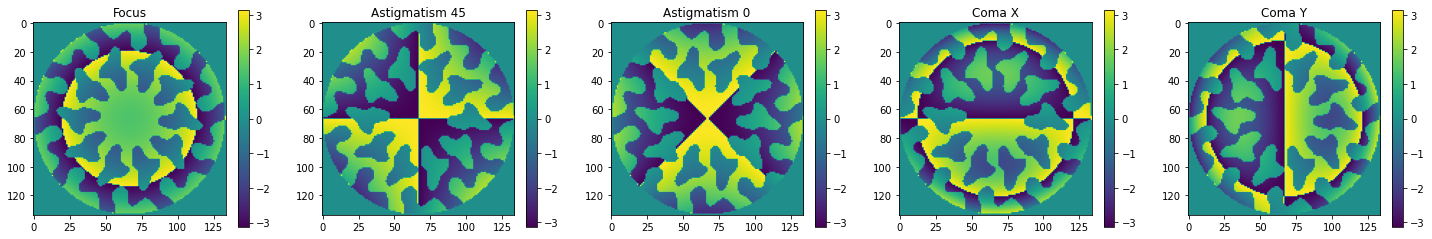

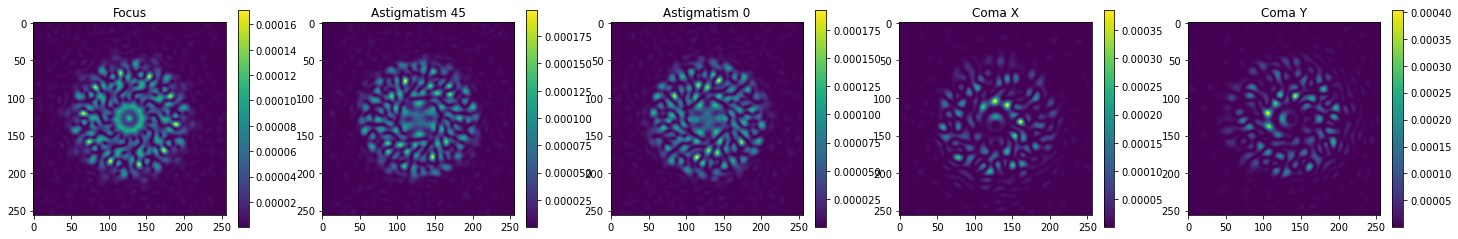

In [10]:
plt.figure(figsize=(25, 4))
for i in range(len(zernikes)):
    plt.subplot(1, 5, i+1)
    plt.imshow(zernikes[i])
    plt.title(zern_names[i])
    plt.colorbar()
plt.show()

plt.figure(figsize=(25, 4))
for i in range(len(zernikes)):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.angle(aberrated_pupil_sample[i]))
    plt.title(zern_names[i])
    plt.colorbar()
plt.show()

plt.figure(figsize=(25, 4))
for i in range(len(zernikes)):
    plt.subplot(1, 5, i+1)
    plt.imshow(aberrated_PSF_sample[i])
    plt.title(zern_names[i])
    plt.colorbar()
plt.show()

In [11]:
nampls = 100
amplitudes = np.linspace(0, 1, nampls)
aberrated_PSFs = []
aberrated_pupils = []
for i in tqdm(range(len(zernikes))):
    aberrated_pupils_temp = []
    aberrated_PSFs_temp = []
    for j in tqdm(range(len(amplitudes)), leave=False):
        zernike_phase = amplitudes[j] * zernikes[i]
        aberrated_pupil = get_wavefront(magnitude, toliman_phase + zernike_phase)
        aberrated_PSF = get_PSF(0, 0, aberrated_pupil, aperture, focal_length, true_wavelength, pixel_size, npixels, array_size)
        aberrated_pupils_temp.append(aberrated_pupil)
        aberrated_PSFs_temp.append(aberrated_PSF)
    aberrated_pupils.append(aberrated_pupils_temp)
    aberrated_PSFs.append(aberrated_PSFs_temp)

In [12]:
toliman_PSF_flat = toliman_PSF.flatten()

correlations_1d = []
for i in tqdm(range(len(zernikes))):
    correlations_temp = []
    for j in tqdm(range(len(amplitudes)), leave=False):
        correlation = jax.scipy.signal.correlate(toliman_PSF_flat, aberrated_PSFs[i][j].ravel())
        correlations_temp.append(correlation)
    correlations_1d.append(correlations_temp)
    
correlations_1d = np.array(correlations_1d)

In [13]:
auto_correlation_1d = jax.scipy.signal.correlate(toliman_PSF_flat, toliman_PSF_flat)

In [14]:
colours = ["tab:blue", "tab:orange", "tab:orange", "tab:green", "tab:green"]
linestyles = ["solid", "solid", "dotted", "solid", "dotted"]
c = len(correlations_1d[0][0])//2
s = 20

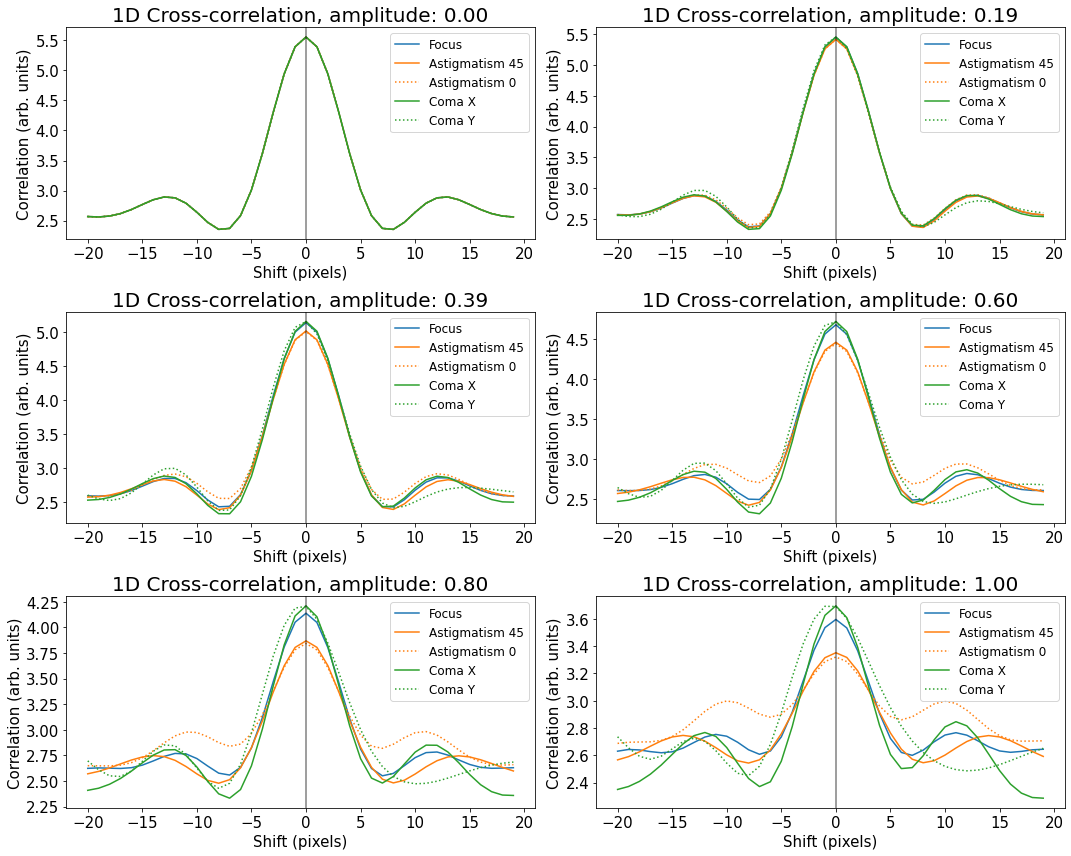

In [62]:
idxs = [1, 20, 40, 60, 80, 100]

plt.figure(figsize=(15, 12))
for i in range(len(idxs)):
    plt.subplot(3, 2, i+1)
    for j in range(len(zernikes)):
        plt.plot(np.arange(-s, s), correlations_1d[j][idxs[i]-1][c-s:c+s]*1e5, 
                 label=zern_names[j], c=colours[j], linestyle=linestyles[j])
    plt.title("1D Cross-correlation, amplitude: {:.2f}".format(amplitudes[idxs[i]-1]), fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel("Correlation (arb. units)", fontsize=15)
    plt.xlabel("Shift (pixels)", fontsize=15)
    plt.legend(fontsize=12)
    plt.axvline(0, c='k', alpha=0.5)

plt.tight_layout()
plt.savefig("1d_crosscorrelation")
plt.show()

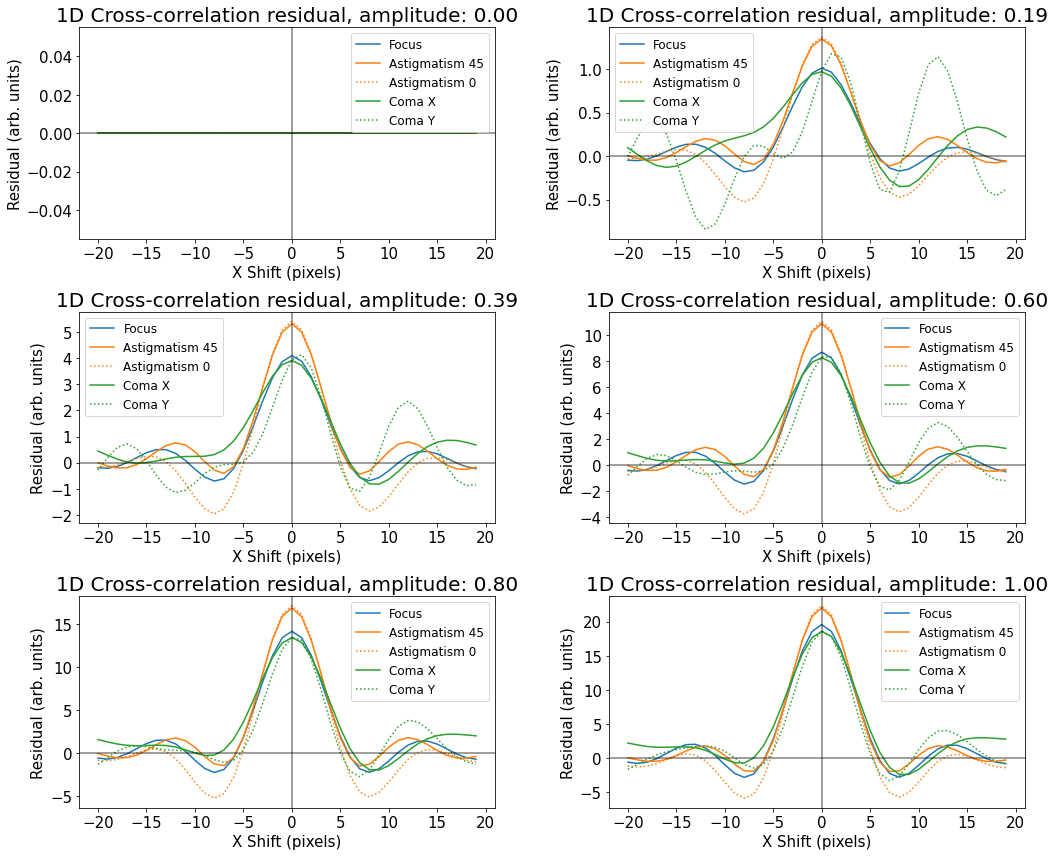

In [63]:
idxs = [1, 20, 40, 60, 80, 100]

plt.figure(figsize=(15, 12))
plt.title("BIG FIG")
for i in range(len(idxs)):
    plt.subplot(3, 2, i+1)
    for j in range(len(zernikes)):
        plt.plot(np.arange(-s, s), (auto_correlation_1d - correlations_1d[j][idxs[i]-1])[c-s:c+s]*1e6, 
                 label=zern_names[j], c=colours[j], linestyle=linestyles[j])
    plt.title("1D Cross-correlation residual, amplitude: {:.2f}".format(amplitudes[idxs[i]-1]), fontsize=20)
    plt.axvline(0, c='k', alpha=0.5)
    plt.axhline(0, c='k', alpha=0.5)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel("Residual (arb. units)", fontsize=15)
    plt.xlabel("X Shift (pixels)", fontsize=15)
    plt.legend(fontsize=12)
    
plt.tight_layout()
plt.savefig("1d_crosscorrelation_residual")
plt.show()

In [17]:
correlations_2d = []
for i in tqdm(range(len(zernikes))):
    correlations_temp = []
    for j in tqdm(range(len(amplitudes)), leave=False):
        correlation = jax.scipy.signal.correlate2d(toliman_PSF, aberrated_PSFs[i][j])
        correlations_temp.append(correlation)
    correlations_2d.append(correlations_temp)
    
correlations_2d = np.array(correlations_2d)

In [18]:
c2d = npixels
s2d = 25
auto_correlation_2d = jax.scipy.signal.correlate2d(toliman_PSF, toliman_PSF)

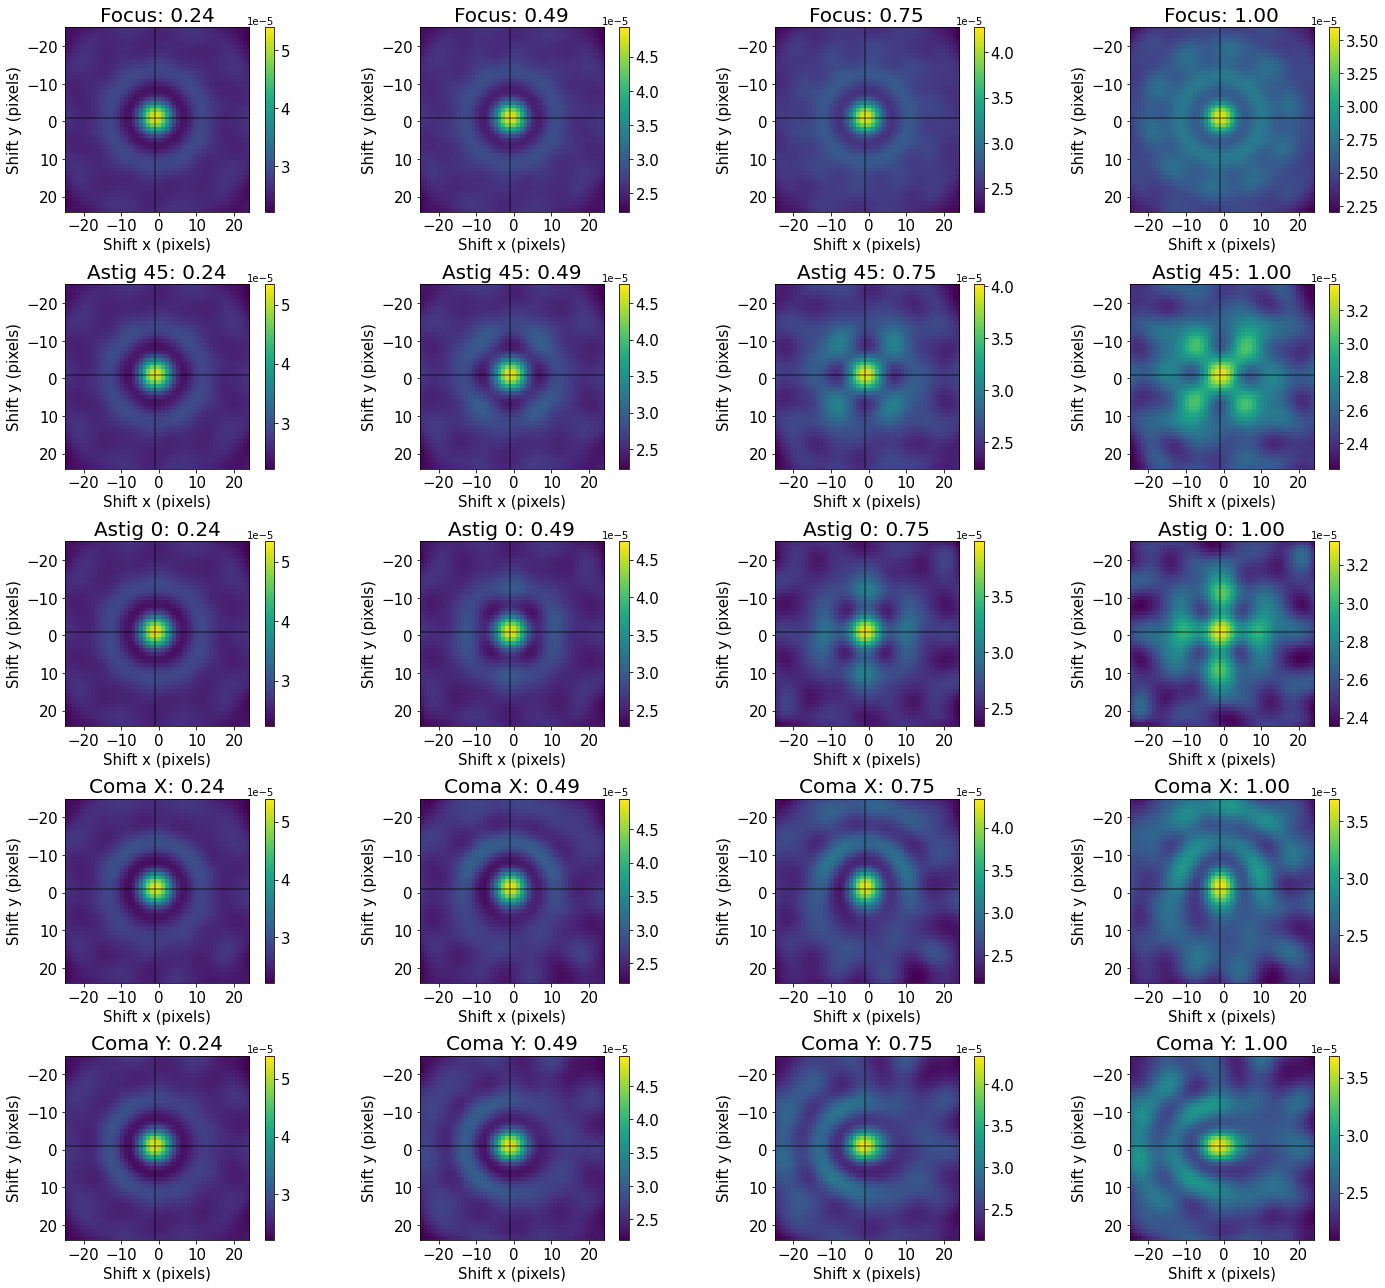

In [84]:
idxs = [25, 50, 75, 100]

idx = 1
plt.figure(figsize=(20, 18))
for j in range(len(zernikes)):
    for i in range(len(idxs)):
        plt.subplot(5, 4, idx)
        plt.imshow(correlations_2d[j][idxs[i]-1][c2d-s2d:c2d+s2d, c2d-s2d:c2d+s2d], extent=(-s2d, s2d-1, s2d-1, -s2d))
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
        plt.axvline(-1, c='k', alpha=0.5)
        plt.axhline(-1, c='k', alpha=0.5)
        plt.xlabel("Shift x (pixels)", fontsize=15)
        plt.ylabel("Shift y (pixels)", fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.title("{}: {:.2f}".format(zern_names_short[j], amplitudes[idxs[i]-1]), fontsize=20)
        idx += 1

plt.tight_layout()
plt.savefig("2d_crosscorrelation")
plt.show()

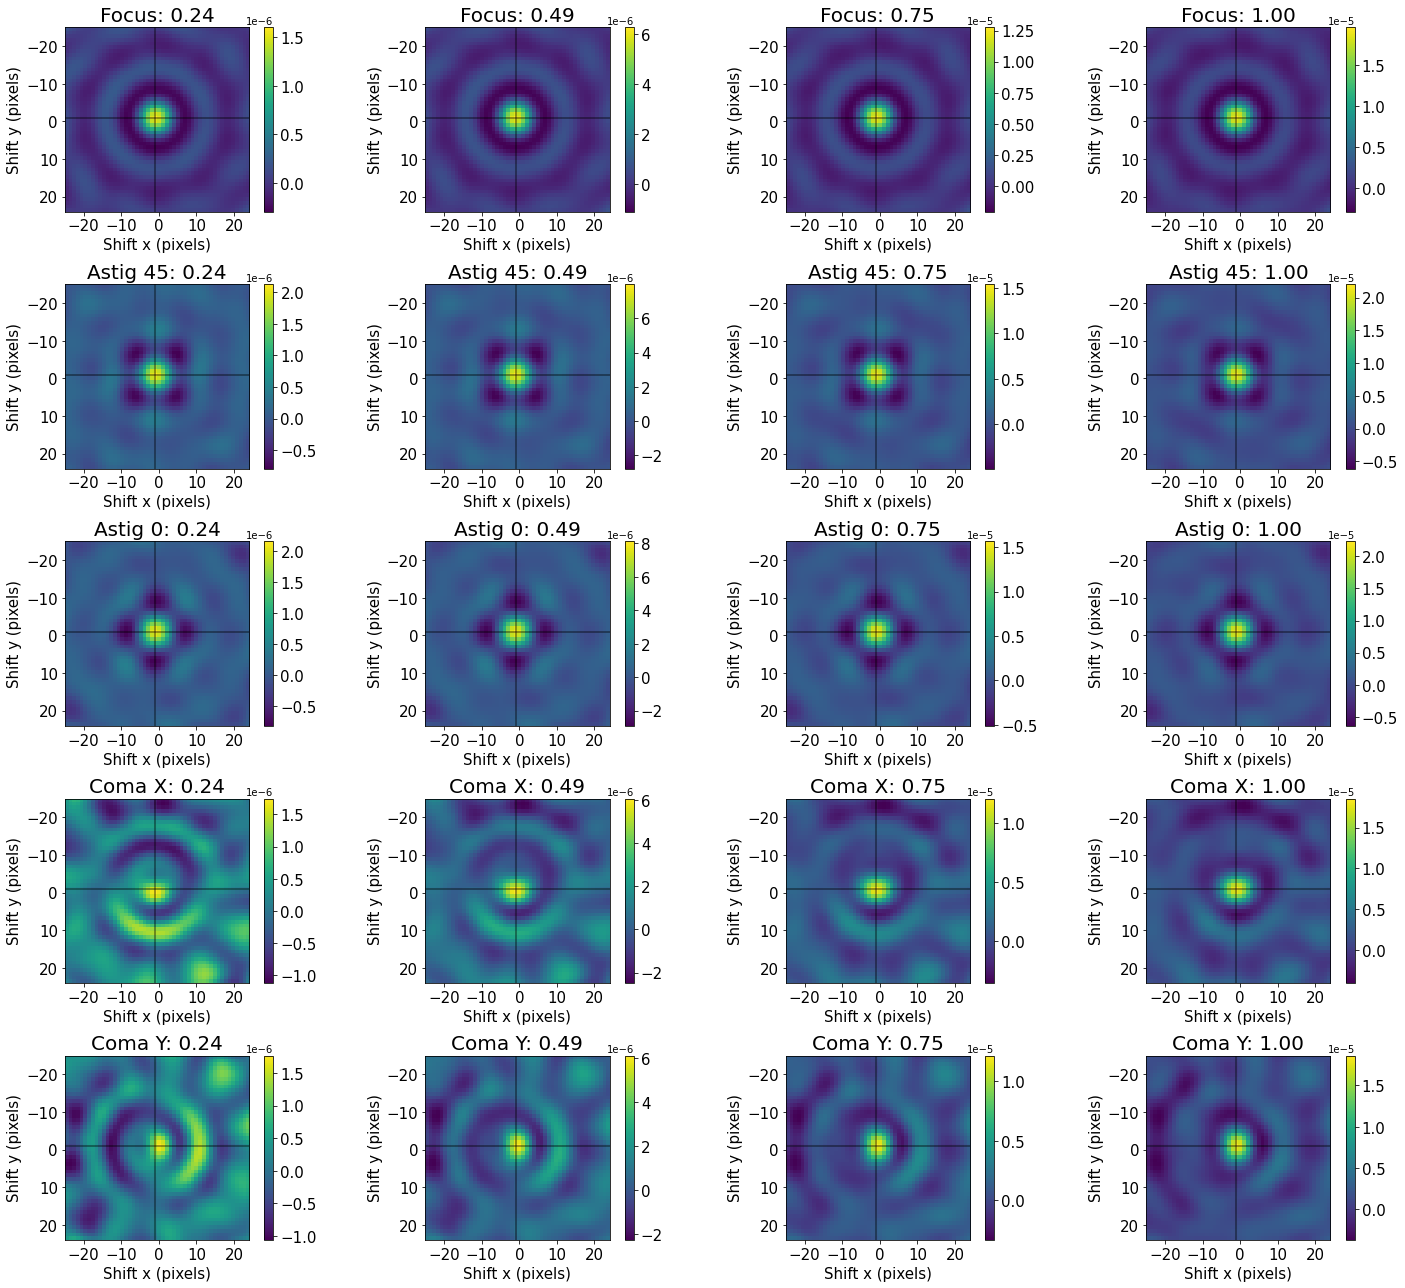

In [87]:
idxs = [25, 50, 75, 100]

idx = 1
plt.figure(figsize=(20, 18))
for j in range(len(zernikes)):
    for i in range(len(idxs)):
        plt.subplot(5, 4, idx)
        plt.imshow((auto_correlation_2d - correlations_2d[j][idxs[i]-1])[c2d-s2d:c2d+s2d, c2d-s2d:c2d+s2d], 
                   extent=(-s2d, s2d-1, s2d-1, -s2d))
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=15)
        plt.axvline(-1, c='k', alpha=0.5)
        plt.axhline(-1, c='k', alpha=0.5)
        plt.xlabel("Shift x (pixels)", fontsize=15)
        plt.ylabel("Shift y (pixels)", fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.title("{}: {:.2f}".format(zern_names_short[j], amplitudes[idxs[i]-1]), fontsize=20)
        idx += 1
    
plt.tight_layout()
plt.savefig("2d_crosscorrelation_residual")
plt.show()